# <b> Open Street Map data from Seattle, WA, USA. </b>

I chose to explore Seattle, WA because I am considering making a move there at some point in the future
and I would like to know if it would be a suitable place for me to live.

I downloaded the raw OSM file (1.61 GB) from:

https://www.openstreetmap.org/export#map=12/47.6065/-122.3321 

with overpass API. 



<b> PROBLEMS </b>

1. From sample file, it's clear that the street names need some cleaning- there are inconsistent abbreviations for direction (NE) and Street, etc.

2. Looked for inconsistencies in labeling in the postcode and didn't find any problems with postcode, house number or city name (surprising!)

3. Those tags of type = 'not' are not in Seattle - get rid of them.

4. Get rid of tags of type = 'removed'.

5. Check out key = 'fixme' - these are tags that need to be fixed so will be removed for now.

6. nodes - types appartment - only one but fix spelling so it can be searched for later.

7. want to look into tiger or josm?

For the first problem, I cleaned up the Street Names, very similarly to how it was done in the previous assignment. The main difference is that I looked up a lot of street names on Google maps based on the lat and lon values in order
to see what the correct street name should be (since in some cases there was only information on the name and not type, e.g. 'Mcgarigle' when it should be 'Mcgarigle Road')

In [2]:
#these are the modules needed for all the code in this project: #

import xml.etree.cElementTree as ET
import pprint
import re
from collections import defaultdict
import pandas as pd
import csv
import codecs
import sqlite3
import numpy as np
import matplotlib as plt
%matplotlib inline

# various raw and sample file names #
in_file = 'seattle_washington.osm' 
sample_file = "seattle_sample.osm"
out_file = 'seattle_fixed.osm'
sample_testing_file ='sample_testing.osm'


In [44]:
# this is the generator function used to iterate across the OSM file, written by Udacity #

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

# this is the function written to write a sample file #
def create_sample_file(in_file, out_file, k=180000):
    with open(out_file, 'wb') as output:
        output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        output.write('<osm>\n  ')

    # Write every kth top level element
        for i, element in enumerate(get_element(in_file)):
            if i % k == 0:
                output.write(ET.tostring(element, encoding='utf-8'))
        output.write('</osm>')
        
#to create sample file, run the function below:
create_sample_file(in_file, sample_file)

 this is the code used both to ascertain street name problems and to fix the street names #

 Let's clean up the streets

 <b> Problem 1: </b>
 Searched through the set of street names that were not in OK_streets 
 and used google maps to assign better names for them, thankfully there weren't *too* many.

In [ ]:
OK_streets = ['Street', 'Court', 'Boulevard', 'Lane', 'Parkway', 'Circle', 'Avenue', 'Place',
              'Drive', 'Square', "Trail", "Commons", 'Northeast', 'Northwest', 'Southwest', 
              "Southeast", 'Park', 'Esplanade', 'Broadway', 'US-101', 'US-2', 'WA-99', "Road", 
              "Plateau" ]

# Street names to fix in both nodes and ways tags
better_st_name = {'Mcgarigle':'Mcgarigle Road',
    'Park': 'Park Lane',
    'bjuin': 'Bjune Drive Southeast',
    'Broad' : 'Broadway',
    'Douglas': 'Douglas Street',
    'Kincaid': 'West Kincaid Street',
    '4114':'187th Avenue Southeast',
    'Roosevelt': 'Roosevelt Avenue',
    'Kulshan': 'Kulshan Avenue',
    'Cleveland': 'Cleveland Avenue',
    'Milwaukee': 'Milwaukee Street',
    'Maple': 'Maple Street',
    'FIXME': '235th Avenue Northeast',
    'http://local.safeway.com/wa/tacoma-1594.html': 'South 56th Street',
    'Yesler': 'Yesler Terrace',
    'Burwell': 'Burwell Street',
    'Snoqualmie': 'Montgomery Street',
    'Market': 'North Market Boulevard',
    'Central': 'Central Way',
    'Myrtle':'Myrtle Street',
    'Murdock':'Murdock Street',
    'Laventure' :  'North Laventure Road',
    'Cleveland': 'Cleveland Avenue',
              'SE':'Southeast',
              'NW':'Northwest',
              'NE': 'Northeast',
              'SW' : 'Southwest',
              'N':'North',
              'S':'South',
              'W':'West',
              'E':'East',
              'St': 'Street',
              'St.':'Street',
              'Rd':'Road',
              'Rd.': 'Road',
              'Ln': 'Lane',
              'Ln.': 'Lane',
              'ST':'Street',
              'Blvd': 'Boulevard',
              'street':'Street',
              'st':'Street',
              'avenue':'Avenue',
              'n':'North',
              'se':'Southeast',
              'Wy':'Way',
              'southwest':'Southwest',
              'Pkwy':'Parkway',
              'W.':'West',
              "PL":'Place',
              'AVENUE':'Avenue',
              'E,':'East',
              "E.":'East',
              'boulevard':'Boulevard',
              'west':'West',
              'south':'South',
              'AVE':'Avenue',
              'S.':'South',
              "ROAD":'Road',
              'N.E.':'Northeast',
              'S.E.':'Southeast',
              'av.':'Avenue',
              'se':'Southeast',
              'Ct':'Court',
              "Blvd.":'Boulevard',
              'WY':'Way'}


# these are the regex compilations used to find problematic addresses, ways, and names

street_name = re.compile(r'\b\S+\.?$', re.IGNORECASE)
match_add = re.compile(r'^addr', re.IGNORECASE) #matches 'addr'
match_way = re.compile(r'[a-zA-Z]*(way)[a-zA-Z]*', re.IGNORECASE) # matches 'way'
match_name = re.compile(r'[a-zA-Z]*(name)[a-zA-Z]*', re.IGNORECASE) # matches 'name'


def is_thing(elem, re_comp): 
    '''Return description of whatever re.comp for an element'''
    addr = re_comp.match(elem)
    if addr:
        return (elem)

def audit_k_name(filename, k_attrib):
    '''Make a set of street names that don't conform to list'''
    not_good = []
    for i, elem in ET.iterparse(filename):
        if elem.tag == 'tag':
            if elem.attrib['k'] in k_attrib:
                sn = street_name.match(elem.attrib['v'])
                if sn:
                    street_type = sn.group(0)
                    if street_type not in OK_streets:
                        not_good.append(street_type)
                    
    return set(not_good)

not_good = audit_k_name(in_file) #contains list of unique attributes that don't match acceptable street names
            


 - the sample file had zero problem street names - that's remarkable - same was not true for the full file
 - that's hilarious, there are 'FIXME' streets! This dataset is literally begging to be fixed :) 
 - The 'FIXME' lat and lon seem to be referring to a cluster of houses located in the 800 block of 235th Ave NE 
 - looked it up on google maps! These were in the node tags.


In [ ]:
def detail_bad_names(filename, not_good): 
    '''Print details of bad street name tags/parents'''
    for i, elem in ET.iterparse(filename):
        if elem.tag == 'node':
            for tag in elem.findall('tag'):
                if tag.attrib['k'] in k_add_fields:
                    if tag.attrib['v'] in not_good:
                        print tag.attrib
        if elem.tag == 'way':
            for tag in elem.findall('tag'):
                if tag.attrib['k']in k_add_fields:
                    if tag.attrib['v'] in not_good:
                        print tag.attrib
        if elem.tag == 'relationships':
            for tag in elem.findall('tag'):
                if tag.attrib['k'] in k_add_fields:
                    if tag.attrib['v'] in not_good:
                        print tag.attrib


def contains_thing(infile):
    '''Print set of attributes that match whatever re.comp set in is_thing()'''
    x = []
    na = []
    for element in get_element(infile):
        if element.tag == 'node':
            for node in element:
                if node.tag == 'tag':
                    y = node.attrib['k']
                    if is_thing(y, match_way):
                        x.append(y)
                    else:
                        na.append(y)
    print set(x)



#match_add = re.compile(r'^addr:')
add = [match_add.match(i) for i in k]
k_noadd_fields = contains_add(in_file)
detail_bad_names(sample_file, not_good)
k_name_fields = ['name_2', 'name:1995-1996_1', 'name:pt', 'name_1', 'name:arz', 'name:mr', 'name:ko', 'name:kn', 
                 'name:ur', 'name:ar', 'name:cs', 'name:tt', 'name:mg', 'name:ro', 'name:am', 'name:it', 'name:tl', 
                 'name:zh-min-nan', 'name:ru', 'name:pl', 'name:ta', 'name:2004-2007_1', 'name:ca', 'name:af', 
                 'name:vi', 'name:fa', 'name_old', 'name:fi', 'name:hi', 'name:de', 'name:pi', 'name:fr', 'name:vo', 
                 'name:zh', 'name:hy', 'name:1999-2004', 'name:1996-1997', 'name:lv', 'name:ja', 'name:lt', 'name:uz', 
                 'name:1995-1996', 'name:he', 'name:1987-1989', 'name:bs', 'name:bn', 'name:la', 'name:2012-2014', 
                 'name3', 'name:uk', 'name:2004-2007', 'name:be', 'name:ug', 'name:bg', 'name:hr', 'name:eo', 'name:en', 
                 'name', 'name:th', 'name:sv', 'name:war', 'STREETNAME', 'name:nl', 'name:es', 'name:sal']
k_way_fields = ['raceway', 'aerialway', 'railway:local_operated', 'cycleway', 'railway:signal:direction', 'aeroway', 
                'railway:signal:form', 'railway:traffic_mode', 'takeaway', 'railway:signal:main:states', 'railway', 
                'railway:signal:main:height', 'railway:position', 'waterway', 'highway', 'highway:lanes']


 didn't see anything from analysis above that I thought would be a problem later.
 
 
 <b>  Problem #2- postcode housecode or city problems? </b>

In [ ]:


def audit_addresses(filename): 
    '''Check out unique instances of k and v attributes - need to be cleaned?'''
    x = []
    for elem in get_element(filename):
        if elem.tag == 'node':
            for node in elem:
                if node.tag == "tag":
                    if node.attrib['k'] == 'addr:city':
                        city_match = re.compile(r'([a-zA-z]*)')
                        city = city_match.match(node.attrib['v'])
                        if city:
                            pass
                        else:
                            x.append(1)
                    if node.attrib['k'] == 'addr:housenumber':
                        housenumber_match = re.compile(r'(\d*)')
                        hn = housenumber_match.match(node.attrib['v'])
                        if hn:
                            pass
                        else:
                            x.append(1)
                    if node.attrib['k'] == 'addr:postcode':
                        zip_match = re.compile(r'(\d{5})')
                        zipcode = housenumber_match.match(node.attrib['v'])
                        if zipcode:
                            pass
                        else:
                            x.append(1)
        if elem.tag == 'way':
            for node in elem:
                if node.tag == "tag":
                    if node.attrib['k'] == 'addr:city':
                        city_match = re.compile(r'([a-zA-z]*)')
                        city = city_match.match(node.attrib['v'])
                        if city:
                            pass
                        else:
                            x.append(1)
                    if node.attrib['k'] == 'addr:housenumber':
                        housenumber_match = re.compile(r'(\d*)')
                        hn = housenumber_match.match(node.attrib['v'])
                        if hn:
                            pass
                        else:
                            x.append(1)
                    if node.attrib['k'] == 'addr:postcode':
                        zip_match = re.compile(r'(\d{5})')
                        zipcode = housenumber_match.match(node.attrib['v'])
                        if zipcode:
                            pass
                        else:
                            x.append(1)
    return x





 Any wonky lat or lon values?
 originally searched for lat and lon values with 5 or more decimal places, but the shorter ones are accurate,
 I looked them up in google maps


In [ ]:
def audit_lat_lon(filename, tag):
    lat_correct = re.compile(r'(\d{2}.\d{3,})')
    lon_correct = re.compile(r'(\-\d{3}.\d{3,})')
    for i, elem in ET.iterparse(filename):
        if elem.tag == tag:
            lat = lat_correct.match(elem.attrib['lat'])
            lon = lon_correct.match(elem.attrib['lon'])
            if not lat:
                print elem.attrib
            if not lon:
                print elem.attrib  

<b> Useful Link for lat/lon verification </b>

http://stevemorse.org/jcal/latlonbatch.html?direction=reverse - addresses from lat,lon!


key: bckGCEiAxEZfQPibAdzayYUcvJ0c8RoA


In [ ]:
audit_addresses(in_file)

#dang, all the addr:things check out. Let's move on!

The following functions are written to fix the street names in the OSM file and re-write the OSM file

In [ ]:
def update_name(name, mapping):
    '''will update street name if it matches the street name regex'''
    m = street_name.search(name)
    try:
        mapping[m.group()]
        new_name = re.sub(street_name, mapping[m.group()], name)
        return new_name
    except:
        return name
    


def write_new_file(infile, outfile):
    '''writes a new OSM file with fixed street names'''
    with open(outfile, 'w') as outfile:
        outfile.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        outfile.write('<osm>\n  ')
        counter = 0
        for element in get_element(infile):
            if element.tag == 'node':
                if element.findall('tag'):  
                    for node in element:
                        if node.attrib['k'] == 'addr:street': 
                            new_name = update_name(node.attrib['v'], better_st_name)
                            node.attrib['v'] = new_name
                    outfile.write(ET.tostring(element, encoding='utf-8'))
                    outfile.write('</node>\n    ')
                if element.findall('tag') == []:
                    outfile.write(ET.tostring(element, encoding='utf-8'))
            if element.tag == 'way':
                element_top = ET.tostringlist(element, encoding='utf-8')
                outfile.write(''.join(map(str, element_top[0:8])))
                outfile.write('\n        ')
                for node in element:
                    if node.tag == 'tag':
                        if node.attrib['k'] == 'addr:street':
                            new_name = update_name(node.attrib['v'], better_st_name)
                            node.attrib['v'] = new_name
                            outfile.write(ET.tostring(node, encoding = 'utf-8'))
                        else:
                            outfile.write(ET.tostring(node, encoding='utf-8'))
                    else:
                        outfile.write(ET.tostring(node, encoding = 'utf-8'))
                outfile.write('</way>\n    ')
            if element.tag == 'relation':
                ET.tostring(element, encoding='utf-8')
        outfile.write('</osm>')
 



#if __name__ == '__main__':
#    write_new_file(in_file, out_file )


 Double check that the same # of nodes, ways and relations exist in edited osm file and original
 this is just to make sure nothing is wrong with my write_new_file function and we get everything out that we need

In [ ]:
def count_elements(infile):
    num_node = 0
    num_way = 0
    num_relation = 0
    num_JOSM = 0
    for element in get_element(infile):     
        if element.tag == 'node':
            for node in element:
                if node.tag == 'tag':
                    if node.attrib['v'] == 'JOSM':
                        num_JOSM +=1
            num_node += 1
        if element.tag == 'way':
            num_way += 1
        if element.tag == 'relation':
            num_relation += 1
    print 'file:' '{} {}{} {}{} {}{}'.format(in_file, 'number of ways:', num_way, 'number of JOSM:', 
                              num_JOSM,'number of relations:', num_relation)
            
# at one point I was concerned about the JOSM entries, but they checked out OK.
# count_elements(in_file), count_elements(out_file) 

Write files to csv for import into Sqlite3
many of these functions are modified from the last assignment before this project
that includes process_map, UnicodeDictWriter, get_element, shape_element and parse_type_attribute





In [ ]:
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"
REL_TAGS_PATH = 'rel_tags.csv'
REL_MEMBERS_PATH = 'rel_members.csv'
RELS_PATH = 'relations_nodes.csv'

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

in_file = 'seattle_fixed.osm'

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']
REL_TAGS_FIELDS = ['id','key','value','type']
REL_MEMBERS_FIELDS = ['reference', 'role', 'type']
REL_FIELDS = ['id','user','uid','version','changeset', 'timestamp']


def shape_element(elem):   
    node_attribs = dict.fromkeys(NODE_FIELDS) #dictionary of node parent
    ways_attribs = dict.fromkeys(WAY_FIELDS) #dictionary of ways parent
    node_tags= [] #list of dictionaries of node parent, tags children
    way_tags = [] #list of dictionaries of way parent, tags children
    way_nodes = [] # list of dictionaries of way parent, nd children
    rel_attribs = dict.fromkeys(REL_FIELDS)
    rel_members = []
    rel_tags = []
    count = 0
    if elem.tag == 'way':
        id_way = elem.attrib['id']
        ways_attribs['id'] = elem.attrib['id']
        ways_attribs['user'] = elem.attrib['user']
        ways_attribs['uid'] = elem.attrib['uid']
        ways_attribs['version'] = elem.attrib['version']
        ways_attribs['changeset'] = elem.attrib['changeset']
        ways_attribs['timestamp'] = elem.attrib['timestamp']
        for node in elem:  
            if node.tag =='tag':
                t, k = parse_type_attrib(node)
                if k == None:
                    pass 
                else:
                    if t:
                        way_dict = {'id' : id_way,
                                     'value' : node.attrib['v'],
                                     'key' : k,
                                    'type' : t}
                    else:
                        way_dict = {'id' : id_way,
                                     'value' : node.attrib['v'],
                                     'key' : k,
                                    'type' : 'regular'}
                    way_tags.append(way_dict)
            if node.tag == 'nd':
                way_nodes_dict = {'id' : id_way,
                                'node_id' : node.attrib['ref'],
                                'position': count}
                way_nodes.append(way_nodes_dict)
                count += 1           
        return {'way': ways_attribs, 'way_nodes': way_nodes, 'way_tags': way_tags}
    if elem.tag == 'node':
        if len(elem.attrib.keys())== 8:
            id_node = elem.attrib['id']
            node_attribs['id'] = elem.attrib['id']
            node_attribs['user'] = elem.attrib['user']
            node_attribs['lat'] = elem.attrib['lat']
            node_attribs['lon'] = elem.attrib['lon']
            node_attribs['uid'] = elem.attrib['uid']
            node_attribs['version'] = elem.attrib['version']
            node_attribs['changeset'] = elem.attrib['changeset']
            node_attribs['timestamp'] = elem.attrib['timestamp']
            for node in elem:
                if node.tag == 'tag':
                    t, k = parse_type_attrib(node)
                    if k == None: 
                        pass                 
                    else:
                        if t:
                            node_dict = {'id' : id_node,
                                 'value' : node.attrib['v'],
                                 'key' : k,
                                'type' : t}   
                        else:
                            node_dict = {'id' : id_node,
                                 'value' : node.attrib['v'],
                                 'key' : k,
                                'type' : 'regular'}
                            
                        node_tags.append(node_dict)
                else:
                    node_tags.append([])       
        return {'node': node_attribs, 'node_tags': node_tags}
    if elem.tag == 'relation':
            id_relation = elem.attrib['id']
            rel_attribs['id'] = elem.attrib['id']
            rel_attribs['user'] = elem.attrib['user']
            rel_attribs['uid'] = elem.attrib['uid']
            rel_attribs['version'] = elem.attrib['version']
            rel_attribs['changeset'] = elem.attrib['changeset']
            rel_attribs['timestamp'] = elem.attrib['timestamp']
            for node in elem:
                if node.tag == 'tag':
                    t, k = parse_type_attrib(node)
                    if k == None: 
                        pass                 
                    else:
                        if t:
                            rel_dict = {'id' : id_relation,
                                 'value' : node.attrib['v'],
                                 'key' : k,
                                'type' : t}   
                        else:
                            rel_dict = {'id' : id_relation,
                                 'value' : node.attrib['v'],
                                 'key' : k,
                                'type' : 'regular'}
                            
                        rel_tags.append(rel_dict)  
                if node.tag == 'member':  
                    rel_members_dict = {'reference' : node.attrib['ref'],
                                        'role' : node.attrib['role'],
                                        'type': node.attrib['type']} 
                    rel_members.append(rel_members_dict) 
            return {'relation': rel_attribs, 'rel_tags': rel_tags, 'rel_members': rel_members}
        
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()



def parse_type_attrib(elem):      
    before = re.compile(r'^([a-z]+):') #pattern to find ahead of :
    tag_key = re.compile(r'^[a-z]+:([a-z]+:?[a-z]+.?[a-z]*)') #pattern to find after :
    PROBLEMCHARS = re.compile(r'([=\+\/&<>;\'"\?%#$@\,\. \t\r\n])')
    m = before.search(elem.attrib['k'])
    l = tag_key.search(elem.attrib['k'])
    pc = PROBLEMCHARS.search(elem.attrib['k'])
    if pc:
        t = None
        k = None  
        return t, k 
        pass
    if m:
        
        t = m.group(1)    
    if l:
        
        k = l.group(1)   
    else:
        
        k = elem.attrib['k'] 
        t = None
    return t, k
            


def process_map(file_in): ## ADD RELATIONS
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
        codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
        codecs.open(WAYS_PATH, 'w') as ways_file, \
        codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
        codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file, \
        codecs.open(REL_TAGS_PATH, 'w') as rel_tags_file, \
        codecs.open(REL_MEMBERS_PATH, 'w') as rel_members_file, \
        codecs.open(RELS_PATH, 'w') as rel_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)
        rel_tags_writer = UnicodeDictWriter(rel_tags_file, REL_TAGS_FIELDS)
        rel_members_writer = UnicodeDictWriter(rel_members_file, REL_MEMBERS_FIELDS)
        rels_writer = UnicodeDictWriter(rel_file, REL_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()
        rel_tags_writer.writeheader()
        rel_members_writer.writeheader()
        rels_writer.writeheader()

        for element in get_element(file_in, tags=('node', 'way', 'relation')):
            el = shape_element(element)
            if el:
                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])
                elif element.tag == 'relation':
                    rels_writer.writerow(el['relation'])
                    rel_members_writer.writerows(el['rel_members'])
                    rel_tags_writer.writerows(el['rel_tags'])

class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

#if __name__ == '__main__':
#    process_map(in_file)

Since the csv files are easier to handle than the OSM files, this is a good time to look through the data 
in a little more detail, using pandas (because pandas is so cool!!)


In [ ]:
way_nodes = "ways_nodes.csv"
ways_tags = "ways_tags.csv"
nodes_tags = "nodes_tags.csv"
ns = "nodes.csv"

w_nodes = pd.read_csv(way_nodes)
w_tags = pd.read_csv(ways_tags)
n_tags = pd.read_csv(nodes_tags)
nodes = pd.read_csv(ns)

n_values = n_tags['value'].unique() # see unique values of nodes



In [ ]:
## Remove the key values of 'fixme' and 'removed' from csv files
# there are over 2000 places where key = 'fixme'    
# in the ways and nodes fields, these are incomplete entries and have been removed.

w_tags = w_tags[w_tags['key'] != 'fixme']
n_tags = n_tags[n_tags['key'] != 'fixme'] 
w_tags = w_tags[w_tags['type'] != 'not']
n_tags = n_tags[n_tags['type'] != 'not']
w_tags = w_tags[w_tags['type'] != 'removed']
n_tags = n_tags[n_tags['type'] != 'removed']



# 'centre' should be changed to 'center' in the value column
index_centre = n_tags[n_tags['value'] == 'centre'].index.tolist()
n_tags.iloc[index_centre,2] = 'center'

# need to convert date time to something sqlite3 can handle?
'''A time string can be in any of the following formats:

YYYY-MM-DD
YYYY-MM-DD HH:MM
YYYY-MM-DD HH:MM:SS
YYYY-MM-DD HH:MM:SS.SSS
YYYY-MM-DDTHH:MM
YYYY-MM-DDTHH:MM:SS
YYYY-MM-DDTHH:MM:SS.SSS
HH:MM
HH:MM:SS
HH:MM:SS.SSS
now
DDDDDDDDDD

https://www.sqlite.org/lang_datefunc.html
'''

# ...it can handle it fine!


## replace old csv files with new ones
n_tags.to_csv('nodes_tags.csv', index=False)
w_tags.to_csv('ways_tags.csv', index=False)

One of the things I absolutely HAVE to know about Seattle if I'm ever going to move there is whether there are enough indian restaurants to fulfill my frequent cravings. I was concerned about how the cuisine entries were entered (i.e., are all of the types of restaurants categorized in a way that makes sense?)

In [ ]:
uni_cuisine_types = all_rest['value'][all_rest['key'] == 'cuisine'].index.tolist()

turns out there are three different ways that indian restaurants are categorized: 'indian', 'Nepalese,_Indian,_Tibetan', and 'Indian,_South_East_Asian'. I decided to change all of these to 'indian' to make it easier to access the information on indian restaurants.

In [ ]:
indian_id1 = n_tags[n_tags['value'] == 'Nepalese,_Indian,_Tibetan'].index.tolist()
indian_id2 = n_tags[n_tags['value'] == 'Indian,_South_East_Asian'].index.tolist()


n_tags.iloc[indian_id1,2] = 'indian'
n_tags.iloc[indian_id2, 2]= 'indian'

# Import .csv files into sqlite3 and QUERY!

In [6]:
#within the sqlite3 command line I input:
'''
.open seattle.db
create table ways_tags(id, key, value, type);
.mode csv
.import way_tags.csv way_tags
create table ways_tags(id, key, value, type);
.mode csv
.import ways_tags.csv ways_tags
create table ways(id, user, uid, version, changeset, timestamp);
.mode csv
.import ways.csv ways
create table ways_nodes(id, node_id, position);
.mode csv
.import ways_nodes.csv ways_nodes
create table rels_members(reference, role, type);
.mode csv
.import rels_members.csv rels_members
create table rels_tags(id, key, value, type);
.mode csv
.import rels_tags.csv rels_tags
create table relations(id, user, uid, version, changeset, timestamp)
.mode csv
.import relations.csv relations
'''


'\n.open seattle.db\ncreate table ways_tags(id, key, value, type);\n.mode csv\n.import way_tags.csv way_tags\ncreate table ways_tags(id, key, value, type);\n.mode csv\n.import ways_tags.csv ways_tags\ncreate table ways(id, user, uid, version, changeset, timestamp);\n.mode csv\n.import ways.csv ways\ncreate table ways_nodes(id, node_id, position);\n.mode csv\n.import ways_nodes.csv ways_nodes\ncreate table rels_members(reference, node_id, position);\n.mode csv\n.import rels_members.csv rels_members\ncreate table rels_tags(id, key, value, type);\n.mode csv\n.import rels_tags.csv rels_tags\ncreate table relations(id, user, uid, version, changeset, timestamp)\n.mode csv\n.import relations.csv relations\n'

# Finally, SQL queries


In [18]:
conn = sqlite3.connect('seattle.db')
c = conn.cursor()

I found a problem while looking through the csv files in sqlite3
    - Seattle, WA is located in Kings County. Any counties listed that are not King County are not in Seattle!
    - Going to look into these and see if they should be removed or if they describe roads that traverse Seattle.

In [36]:
c.execute('''SELECT DISTINCT value FROM ways_tags
            WHERE key = "county";''')

counties = c.fetchall()

counties_df = pd.DataFrame.from_records(counties)
print counties_df


c.execute('''SELECT ways_tags.id, ways_tags.value, ways_tags.key FROM 
(SELECT id FROM ways_tags WHERE value = 'Yakima, WA') yak
JOIN ways ON ways.id = yak.id
JOIN ways_tags ON ways_tags.id = yak.id;''')


yakima = c.fetchall()

df_yak = pd.DataFrame.from_records(yakima)
df_yak.columns = ['id', 'value', 'key']
print df_yak

c.execute('''SELECT COUNT(*) FROM ways_tags
               WHERE key = 'reviewed' AND value = 'no';''')
not_rev = float(c.fetchall()[0][0])
percent = round((not_rev/float(1048576))*100,2)
print 'This many tags have not been reviewed: {}.'.format(not_rev)
print 'This means that {}% may be inaccurate!!'.format(percent)

# in terms of the Yakima entries - they are no where near Seattle and haven't been reviewed - so getting rid of them.
# there are over 84,000 entries that have not been reviewed!! 


                                 0
0                       Pierce, WA
1                         King, WA
2                    Snohomish, WA
3                      Clallam, WA
4                 Grays Harbor, WA
5       Grays Harbor, WA;Mason, WA
6    Grays Harbor, WA:Thurston, WA
7                       Island, WA
8   Grays Harbor, WA;Jefferson, WA
9                    Jefferson, WA
10                      Kitsap, WA
11            Kitsap, WA:Mason, WA
12                    Kittitas, WA
13           Kittitas, WA;King, WA
14                        Kittitas
15                       Lewis, WA
16          Lewis, WA;Thurston, WA
17                       Mason, WA
18                    Thurston, WA
19            Lewis, WA:Pierce, WA
20     Mason, WA; Grays Harbor, WA
21      Mason, WA;Grays Harbor, WA
22           Cowlitz, WA:Lewis, WA
23                     Pacific, WA
24          Thurston, WA;Lewis, WA
25                      Yakima, WA
26            King, WA; Pierce, WA
27          King, WA

#Number of ways

SELECT COUNT(*) from ways;
703369

#Number of nodes

SELECT COUNT(*) from nodes;
7205689

#number of node-tags

SELECT COUNT(*) from nodes_tags;
1058171


## number of entries:
<pre>

|DATA_Type        |Num_instances|
|-----------------|-------------|
|ways             |       703369|
|-----------------|-------------|
|nodes            |      7205689|
|-----------------|-------------|
|relations        |         7999|
|-----------------|-------------|
|ways-tags        |      3492472|
|-----------------|-------------|
|ways-nodes (nd)  |      8006058|
|-----------------|-------------|
|nodes-tags       |      1058171|
|-----------------|-------------|
|relations-tags   |        33786|
|-----------------|-------------|
|relations_members|        59282|

</pre>
#Number of unique users from ways table

SELECT COUNT(DISTINCT uid) FROM ways;
2069

#Number of unique users from nodes table

SELECT COUNT(DISTINCT uid) FROM nodes;
2637

#Number of unique users from relations table

SELECT COUNT(DISTINCT uid) FROM relations;
313


# Relations Information
 - ## How many records have been contributed by unique users?
 - ## How many records have been entered (total) each month in the year 2015? (for relations table)
 - ## How many records have been entered each year?
 

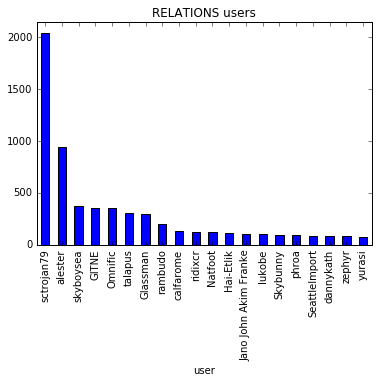

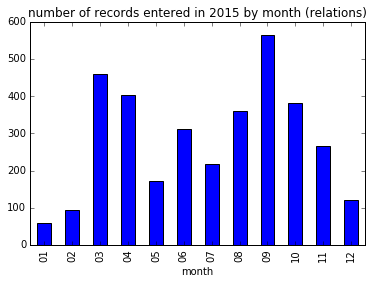

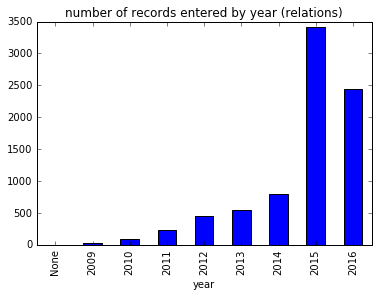

In [11]:
c.execute('''SELECT DISTINCT user, count(*) as num FROM relations
            GROUP BY user
            ORDER BY num desc;''') 

all_rows_rel = c.fetchall()

df  = pd.DataFrame.from_records(all_rows_rel)
rel_user_plot = df[0:20]
rel_user_plot.columns = ['user', 'count']
rel_user_plot.plot(x='user', y = 'count', legend=False, kind='bar', ylim=(0,2150), title='RELATIONS users')


c.execute('''SELECT strftime('%m', timestamp) as month, COUNT(id) as num
             FROM relations
             WHERE strftime('%Y', timestamp) = '2015'
             GROUP BY month;''')

rel_2015 = c.fetchall()
rel_month_plot  = pd.DataFrame.from_records(rel_2015)
rel_month_plot.columns = ['month', 'num_records']
rel_month_plot.plot(x='month', y = 'num_records', legend=False, kind='bar', title='number of records entered in 2015 by month (relations)')

#looks like February by far is the month with the highest number of records entered at least in 2015
# How many records were input by year?

c.execute('''SELECT strftime('%Y', timestamp) as year, COUNT(id) as num
            FROM relations
            GROUP BY year;''')
rel_years = c.fetchall()

rel_year_plot = pd.DataFrame.from_records(rel_years)
rel_year_plot = rel_year_plot[0:11]
rel_year_plot.columns = ['year', 'num_records']
rel_year_plot.plot(x='year', y='num_records', legend=False, kind='bar', title = 'number of records entered by year (relations)')

Looks like sctrojan79 is the contributer with the most entries in the relations table. I looked sctrojan79 up in OSM and it turns out this contributer contributes to both the Seattle, WA and Los Angeles, CA OSM databases. I would be willing to make a bet they attend or attended USC! 

The most prolific input time appears to be September (at least for 2015) and 2015 is the year that has the greatest number of entries (aside from 2016 since that year hasn't ended yet..). Entries didn't begin until 2009, which is 2 years later than the ways and nodes!

# Nodes Information
 - ## How many records have been contributed by unique users?
 - ## How many records have been entered (total) each month in the year 2015? (for nodes table)
 - ## How many records have been entered each year?
 

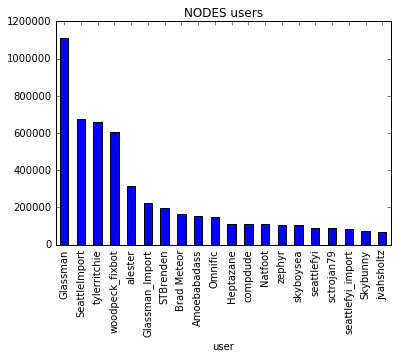

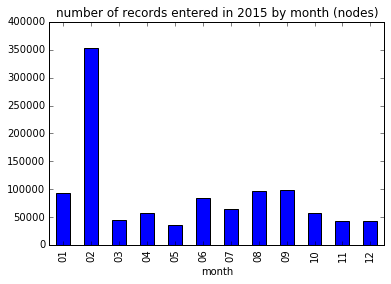

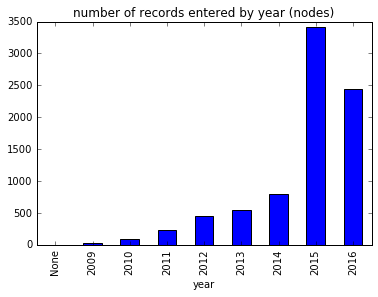

In [12]:
c.execute('''SELECT DISTINCT user, count(*) as num FROM nodes
            GROUP BY user
            ORDER BY num desc;''') # use your column names here

all_rows_nodes = c.fetchall()

df  = pd.DataFrame.from_records(all_rows_nodes)
node_user_plot = df[0:20]
node_user_plot.columns = ['user', 'count']
node_user_plot.plot(x='user', y = 'count', legend=False, kind='bar', title='NODES users')


c.execute('''SELECT strftime('%m', timestamp) as month, COUNT(id) as num
             FROM nodes
             WHERE strftime('%Y', timestamp) = '2015'
             GROUP BY month;''')

node_2015 = c.fetchall()
node_month_plot  = pd.DataFrame.from_records(node_2015)
node_month_plot.columns = ['month', 'num_records']
node_month_plot.plot(x='month', y = 'num_records', legend=False, kind='bar', title='number of records entered in 2015 by month (nodes)')


#looks like February by far is the month with the highest number of records entered at least in 2015
# How many records were input by year?
c.execute('''SELECT strftime('%Y', timestamp) as year, COUNT(id) as num
            FROM nodes
            GROUP BY year;''')
node_years = c.fetchall()

node_year_plot = pd.DataFrame.from_records(rel_years)
node_year_plot = node_year_plot[0:11]
node_year_plot.columns = ['year', 'num_records']
node_year_plot.plot(x='year', y='num_records', legend=False, kind='bar', title = 'number of records entered by year (nodes)')


I looked up Glassman, the most prolific contributor of nodes and it turns out Glassman is a leader of OSM in the Washington community and has been making contributions since 2011. Cool!

SeattleImport is a group of volunteers who merged data from seattle.data.gov into OSM ~2013
Another thing that comes up frequently is TIGER and JOSM:
 - TIGER is the Topologically Integrated Geographic Encoding and Referencing system built from US Census Data
 - JOSM is the Java OSM Editor which provides a GUI for people to edit OSM contributions. 
 
In contrast to relations, the most entries in 2015 were entered in February. 
Similary to relations, 2015 was the year with the greatest number of entries (but maybe 2016 will catch up!)

# Ways Information
 - ## How many records have been contributed by unique users?
 - ## How many records have been entered (total) each month in the year 2015? (for ways table)
 - ## How many records have been entered each year?

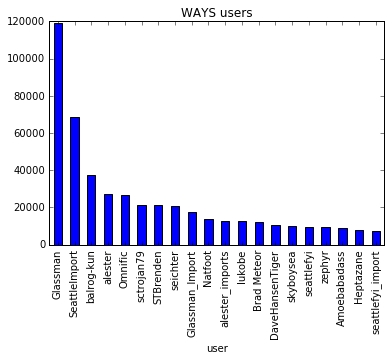

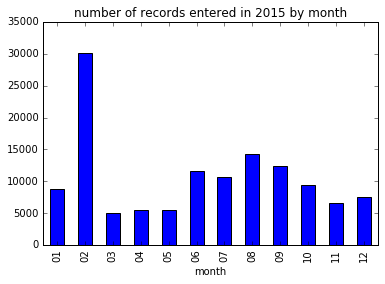

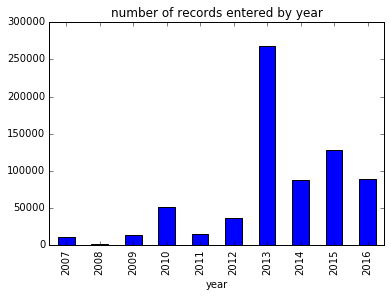

In [13]:
c.execute('''SELECT DISTINCT user, count(*) as num FROM ways
            GROUP BY user
            ORDER BY num desc;''') # use your column names here

all_rows_ways = c.fetchall()

df  = pd.DataFrame.from_records(all_rows_ways)
way_user_plot = df[0:20]
way_user_plot.columns = ['user', 'count']
way_user_plot.plot(x='user', y = 'count', legend=False, kind='bar', title='WAYS users')

c.execute('''SELECT strftime('%m', timestamp) as month, COUNT(id) as num
             FROM ways
             WHERE strftime('%Y', timestamp) = '2015'
             GROUP BY month;''')

year_2015 = c.fetchall()
way_month_plot  = pd.DataFrame.from_records(year_2015)
way_month_plot.columns = ['month', 'num_records']
way_month_plot.plot(x='month', y = 'num_records', legend=False, kind='bar', title='number of records entered in 2015 by month')


#looks like February by far is the month with the highest number of records entered at least in 2015
# How many records were input by year?
c.execute('''SELECT strftime('%Y', timestamp) as year, COUNT(id) as num
            FROM ways
            GROUP BY year;''')
all_years = c.fetchall()

all_year_plot = pd.DataFrame.from_records(all_years)
all_year_plot = all_year_plot[1:11]
all_year_plot.columns = ['year', 'num_records']
all_year_plot.plot(x='year', y='num_records', legend=False, kind='bar', title = 'number of records entered by year')



The ways nodes are not much different from the nodes information- Glassman is still the highest contributor. This is amazing to me because there are large imports that have occurred over the last several years, and Glassman still has those beat! Impressive.

Again, February is the month with the most entries in 2015. But 2013 was the grand year of entries (this is probably because of the Seattle Import that occurred in 2013 that I mentioned before).


Now for my burning question - what is the restaurant situation in Seattle?

# How many of each type of cuisine is there (entered into the db)?

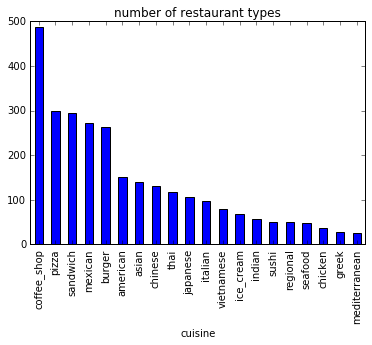

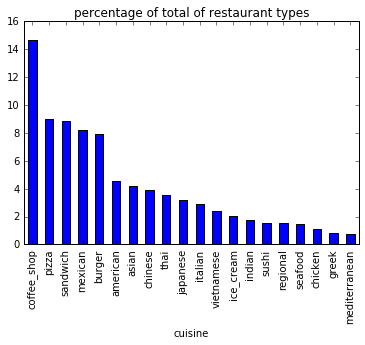

In [15]:


c.execute('''SELECT COUNT(*) as num, value FROM nodes_tags
            WHERE key = "cuisine" 
            GROUP BY value
            ORDER BY num desc;''')
counts_rest = c.fetchall()
counts_rest
df = pd.DataFrame.from_records(counts_rest)
df.columns = ['counts', 'cuisine']
df = df[0:20]
df.plot(x = 'cuisine', y = 'counts', legend = False, kind = 'bar', title = 'number of restaurant types')

c.execute('''SELECT count(id) FROM nodes_tags
            WHERE key = "cuisine";''')

total_cuisine= c.fetchall()

#df['prop'] = (df['counts']/total_cuisine*100)

#props = df['counts'].values/float(total_cuisine)*100
df['prop'] = (df['counts'].values/float(total_cuisine[0][0]))*100

df.plot(x = 'cuisine', y = 'prop', legend = False, kind = 'bar', title = 'percentage of total of restaurant types')

There is the greatest number of entries of coffee shops - no surprise there! About 14% of the cuisine entries are coffee shops. Next in line: pizza, sandwich, mexican, and burger at about 8-9%. Hmmm... I think this might be telling me more about the people entering data than Seattle!

Good news for me - there are at least 20 indian restaurants I could try out!

How many toilets are listed?

SELECT COUNT(*) FROM nodes_tags
WHERE value='toilets';

==> 596! Not bad!

How many bicycle shops?

SELECT COUNT(*) FROM nodes_tags
WHERE value = 'bicycle';

==> 70!

And 7 documented gardens. Seattle sounds like a nice place to live.

# More ideas

 - I think it would be really useful for cuisine values to have a "standard" categorization
   - this of course should probably be extended to many of the value tags, it would just make it easier to find what you're looking for
 - I wish there was some way of knowing how complete the database is
 - Large imports of data should be marked specifically until they are reviewed - most of the problems I have encountered have been from un-reviewed data dumps.
 - In fact, it might be nice for other users to be able to "upvote" or "downvote" entries - this would encourage accurate information while discouraging bad information.
 

# Conclusion

The data for Seattle is expansive and pretty thorough - it seems as if a lot of the information is a combination of large data dumps from SeattleImport and government agencies but a significant portion is also added by individuals, which I find impressive. Part of what makes OSM so great is the ability for anyone to contribute to it. But that aspect is also why it can be difficult to analyze - categories aren't well defined or uniform. I think that some back-end effort could be put in to limit the amount of data that is input without review. Overall I think Seattle sounds like a great place to live and I really enjoyed going through this data and seeing how much information is really out there! 

In [38]:
conn.close()